In [8]:
#Imports
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc


In [37]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv("TCGA.STAD.expression.txt", sep="\t", index_col=0)

print("Original DataFrame:")
print(df.head())
print("Shape:", df.shape)
print("First 5 columns:", df.columns[:5])

# --- Initial Preprocessing ---

# 1. Drop genes with '?' in the column name
question_mark_genes = [col for col in df.columns if '?' in col]
df_cleaned_cols = df.drop(columns=question_mark_genes)
print("\nDataFrame after dropping '?' genes:")
print("Shape:", df_cleaned_cols.shape)

# 2. Keep only letters before '|' in column names
new_columns = [col.split('|')[0] if '|' in col else col for col in df_cleaned_cols.columns]
df_cleaned_cols.columns = new_columns
print("\nDataFrame after renaming columns:")
print("First 5 columns:", df_cleaned_cols.columns[:5])

# 3. Drop columns (genes) with any NaNs
df_no_nan = df_cleaned_cols.dropna(axis=1)
print("\nDataFrame after dropping NaN columns (genes):")
print("Shape:", df_no_nan.shape)

# 4. Filter lowly expressed genes
gene_expression_sum = df_numeric_before_filter.sum(axis=0)  # Sum across columns (genes)
percentile_threshold = 0.10
expression_threshold = gene_expression_sum.quantile(percentile_threshold)
genes_to_keep = gene_expression_sum[gene_expression_sum > expression_threshold].index
df_filtered = df_numeric_before_filter[genes_to_keep].copy()
print("\nDataFrame after filtering lowly expressed genes:")
print("Shape:", df_filtered.shape)

# Log2 transformation
df_log2 = np.log2(df_filtered + 1)
print("\nDataFrame after log2 transformation:")
print(df_log2.head())





Original DataFrame:
                                 sample_id  ?|100130426  ?|100133144  \
patient_id                                                             
TCGA-CG-4460  TCGA-CG-4460-01A-01R-1157-13       0.0000    19.629800   
TCGA-CG-5716  TCGA-CG-5716-01A-21R-1802-13       0.0000    28.658900   
TCGA-HF-7131  TCGA-HF-7131-01A-11R-2055-13       0.4145     5.211200   
TCGA-3M-AB46  TCGA-3M-AB46-01A-11R-A414-31          NaN     9.031233   
TCGA-3M-AB47  TCGA-3M-AB47-01A-22R-A414-31          NaN    11.357840   

              ?|100134869     ?|10357      ?|10431  ?|136542    ?|155060  \
patient_id                                                                 
TCGA-CG-4460    15.746600  107.894000  1095.020000       0.0  132.456000   
TCGA-CG-5716    32.372100    0.000000   983.563000       0.0   81.588900   
TCGA-HF-7131    10.464200    0.696700   935.296000       0.0   47.722700   
TCGA-3M-AB46     9.330910  532.008647  2798.813956       NaN  201.067799   
TCGA-3M-AB47     4.

In [40]:
# Calculate mean and variance for each gene across samples
gene_means = df_log2.mean(axis=0)
gene_vars = df_log2.var(axis=0)

# Calculate dispersion (variance / mean)
dispersion = gene_vars / gene_means

# Filter out genes with very low mean expression to avoid unstable dispersions
min_mean_threshold = gene_means.quantile(0.10)
valid_genes = gene_means[gene_means > min_mean_threshold].index
dispersion_filtered = dispersion[valid_genes]

# Select top 3000 most dispersed genes
top_3000_genes = dispersion_filtered.sort_values(ascending=False).head(3000).index

# Subset the log2-normalized data
df_top3000 = df_log2[top_3000_genes].copy()

df_top3000_z = df_top3000.apply(zscore, axis=0) 
print("done")

done


In [74]:
# --- Run MDS on the top 3000 genes (z-score normalized) using correlation distance ---
# --- MDS directly on df_top3000_z (already sample-wise) ---
dist_matrix = squareform(pdist(df_top3000_z, metric='correlation'))

mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42, normalized_stress='auto')

embedding = mds.fit_transform(dist_matrix)

# Construct MDS DataFrame
mds_df = pd.DataFrame(embedding, columns=['MDS1', 'MDS2', 'MDS3'])

mds_df['sample_id'] = df_top3000_z.index
mds_df['patient_id'] = mds_df['sample_id'].str[:12].str.upper()

# Load metadata & merge
metadata = pd.read_csv("TCGA.STAD.metadata.txt", sep="\t")
metadata['patient_id'] = metadata['patient_id'].str.upper()

mds_merged = mds_df.merge(metadata, on='patient_id', how='inner')
print("Merged rows:", mds_merged.shape[0])


Merged rows: 447


In [75]:
print("mds_df shape:", mds_df.shape)
print("metadata shape:", metadata.shape)


mds_df shape: (447, 5)
metadata shape: (415, 19)


In [76]:
print("\nmds_df sample IDs:")
print(mds_df['sample_id'].head())

print("\nmds_df patient IDs:")
print(mds_df['patient_id'].head())

print("\nmetadata patient IDs:")
print(metadata['patient_id'].head())



mds_df sample IDs:
0    TCGA-CG-4460
1    TCGA-CG-5716
2    TCGA-HF-7131
3    TCGA-3M-AB46
4    TCGA-3M-AB47
Name: sample_id, dtype: object

mds_df patient IDs:
0    TCGA-CG-4460
1    TCGA-CG-5716
2    TCGA-HF-7131
3    TCGA-3M-AB46
4    TCGA-3M-AB47
Name: patient_id, dtype: object

metadata patient IDs:
0    TCGA-3M-AB46
1    TCGA-3M-AB47
2    TCGA-B7-5816
3    TCGA-B7-5818
4    TCGA-B7-A5TI
Name: patient_id, dtype: object


In [77]:
matching_ids = mds_df['patient_id'].isin(metadata['patient_id'])
print("\nHow many patient_ids in mds_df match metadata:", matching_ids.sum(), "of", len(mds_df))



How many patient_ids in mds_df match metadata: 447 of 447


In [78]:
print("Sample mds_df['sample_id']:", mds_df['sample_id'].unique()[:5])
print("Derived mds_df['patient_id']:", mds_df['patient_id'].unique()[:5])
print("metadata['patient_id']:", metadata['patient_id'].unique()[:5])


Sample mds_df['sample_id']: ['TCGA-CG-4460' 'TCGA-CG-5716' 'TCGA-HF-7131' 'TCGA-3M-AB46'
 'TCGA-3M-AB47']
Derived mds_df['patient_id']: ['TCGA-CG-4460' 'TCGA-CG-5716' 'TCGA-HF-7131' 'TCGA-3M-AB46'
 'TCGA-3M-AB47']
metadata['patient_id']: ['TCGA-3M-AB46' 'TCGA-3M-AB47' 'TCGA-B7-5816' 'TCGA-B7-5818'
 'TCGA-B7-A5TI']


In [79]:
print("df_top3000_z shape:", df_top3000_z.shape)
print("df_top3000_z index (should be sample IDs):", df_top3000_z.index[:5])
print("df_top3000_z columns (should be gene names):", df_top3000_z.columns[:5])


df_top3000_z shape: (447, 3000)
df_top3000_z index (should be sample IDs): Index(['TCGA-CG-4460', 'TCGA-CG-5716', 'TCGA-HF-7131', 'TCGA-3M-AB46',
       'TCGA-3M-AB47'],
      dtype='object', name='patient_id')
df_top3000_z columns (should be gene names): Index(['PGA3', 'XIST', 'GSTM1', 'CHGA', 'RPS4Y1'], dtype='object')


/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_52855/2379854104.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set2', len(mds_merged['tumor_status'].unique()))


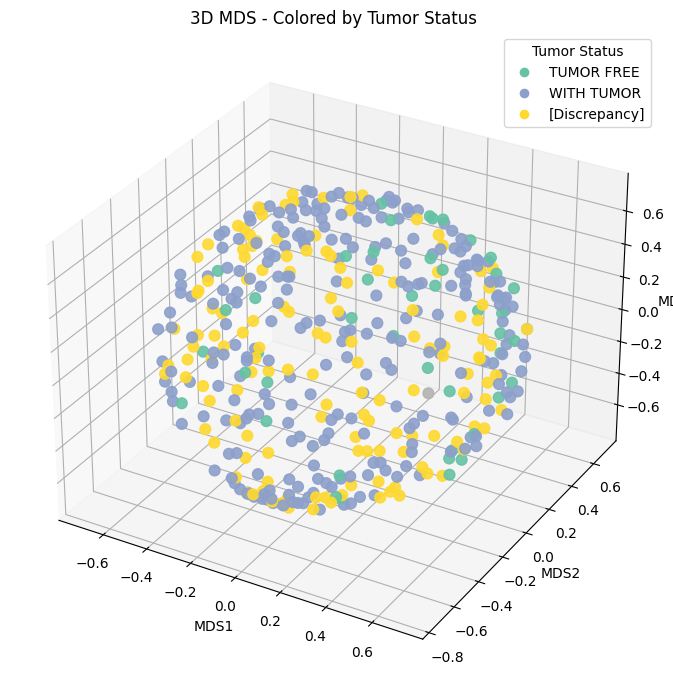

In [83]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import pandas as pd

# Encode tumor_status as numbers for coloring
mds_merged['tumor_status_code'] = mds_merged['tumor_status'].astype('category').cat.codes
cmap = cm.get_cmap('Set2', len(mds_merged['tumor_status'].unique()))

# Create 3D scatter plot
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    mds_merged['MDS1'],
    mds_merged['MDS2'],
    mds_merged['MDS3'],
    c=mds_merged['tumor_status_code'],
    cmap=cmap,
    s=60,
    alpha=0.9
)

# Axes labels
ax.set_title('3D MDS - Colored by Tumor Status')
ax.set_xlabel('MDS1')
ax.set_ylabel('MDS2')
ax.set_zlabel('MDS3')

# Custom legend
tumor_labels = mds_merged['tumor_status'].astype('category').cat.categories
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=cmap(i), markersize=8, label=label)
    for i, label in enumerate(tumor_labels)
]
ax.legend(handles=legend_handles, title='Tumor Status', loc='upper right')

plt.tight_layout()
plt.show()


In [84]:
from sklearn.metrics import silhouette_score

# Columns to test
categorical_cols = [
    'gender', 'race', 'ajcc_pathologic_tumor_stage', 'histological_type',
    'histological_grade', 'tumor_status', 'vital_status', 'type'
]

print("Silhouette Scores (MDS space):\n")
for col in categorical_cols:
    mask = mds_merged[col].notna()
    unique_vals = mds_merged.loc[mask, col].nunique()
    
    if mask.sum() >= 2 and unique_vals >= 2:
        score = silhouette_score(
            mds_merged[['MDS1', 'MDS2','MDS3']][mask],
            mds_merged.loc[mask, col]
        )
        print(f"{col}: {score:.4f}")
    else:
        print(f"{col}: Not enough groups or values to compute score")


Silhouette Scores (MDS space):

gender: 0.0031
race: -0.2152
ajcc_pathologic_tumor_stage: -0.2104
histological_type: -0.2862
histological_grade: -0.0366
tumor_status: -0.1194
vital_status: -0.1615
type: Not enough groups or values to compute score


In [85]:
print(mds_merged.columns.tolist())


['MDS1', 'MDS2', 'MDS3', 'sample_id', 'patient_id', 'type', 'age_at_initial_pathologic_diagnosis', 'gender', 'race', 'ajcc_pathologic_tumor_stage', 'histological_type', 'histological_grade', 'tumor_status', 'vital_status', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction', 'tumor_status_code']


In [87]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Drop missing values
df_model = mds_merged.dropna(subset=['tumor_status'])

X = df_model[['MDS1', 'MDS2','MDS3']]
y = df_model['tumor_status'].astype('category').cat.codes  # encode labels

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Logistic Regression:")
print(classification_report(y_test, lr.predict(X_test)))

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print("Random Forest:")
print(classification_report(y_test, rf.predict(X_test)))


Logistic Regression:
              precision    recall  f1-score   support

           0       0.59      1.00      0.74        48
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00         1

    accuracy                           0.59        81
   macro avg       0.20      0.33      0.25        81
weighted avg       0.35      0.59      0.44        81

Random Forest:
              precision    recall  f1-score   support

           0       0.57      0.75      0.65        48
           1       0.33      0.19      0.24        32
           2       0.00      0.00      0.00         1

    accuracy                           0.52        81
   macro avg       0.30      0.31      0.30        81
weighted avg       0.47      0.52      0.48        81



/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/site-packages/sklearn/metrics/_classificat

In [88]:
# Bin OS.time into short vs long
df_model = mds_merged.dropna(subset=['OS.time']).copy()
df_model['OS_group'] = pd.qcut(df_model['OS.time'], q=2, labels=['Short', 'Long'])

X = df_model[['MDS1', 'MDS2','MDS3']]
y = df_model['OS_group'].astype('category').cat.codes

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Logistic Regression (Survival Group):")
print(classification_report(y_test, lr.predict(X_test)))

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print("Random Forest (Survival Group):")
print(classification_report(y_test, rf.predict(X_test)))


Logistic Regression (Survival Group):
              precision    recall  f1-score   support

           0       0.50      0.51      0.51        45
           1       0.48      0.47      0.47        43

    accuracy                           0.49        88
   macro avg       0.49      0.49      0.49        88
weighted avg       0.49      0.49      0.49        88

Random Forest (Survival Group):
              precision    recall  f1-score   support

           0       0.54      0.60      0.57        45
           1       0.53      0.47      0.49        43

    accuracy                           0.53        88
   macro avg       0.53      0.53      0.53        88
weighted avg       0.53      0.53      0.53        88

